In [1]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import spacy
import en_core_web_sm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews5.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

In [3]:
nlp = en_core_web_sm.load()

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [4]:
df['text'] = [lemmatize_text(sent) for sent in df['text']]

In [5]:
x = df["text"]
y = df["label"].values
y

array([1, 1, 0, ..., 0, 0, 1])

In [6]:
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [7]:
def get_sequence_of_tokens(corpus):
    
    
    total_words = len(tokenizer.word_index) + 1
    
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [8]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.3, random_state=42)

# Setting up RNN


In [10]:
def build_model():
    opt = Adam(lr=1e-4)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(total_words, 64))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

rnn_model = build_model()

In [11]:
!rm -r /tmp/logs/

In [12]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis_rnn.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn = rnn_model.fit(x_train, y_train, epochs = 10, validation_split=0.1, 
                           callbacks = [tb_callback, checkpoint])

Epoch 1/10
 1/65 [..............................] - ETA: 0s - loss: 0.6832 - accuracy: 0.5312WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
65/65 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5423
Epoch 00001: val_loss improved from inf to 0.69114, saving model to /tmp/sentiment_analysis_rnn.hdf5
65/65 [==============================] - 5s 78ms/step - loss: 0.6886 - accuracy: 0.5423 - val_loss: 0.6911 - val_accuracy: 0.5240
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.6429
Epoch 00002: val_loss improved from 0.69114 to 0.68140, saving model to /tmp/sentiment_analysis_rnn.hdf5
65/65 [==============================] - 5s 70ms/step - loss: 0.6582 - accura

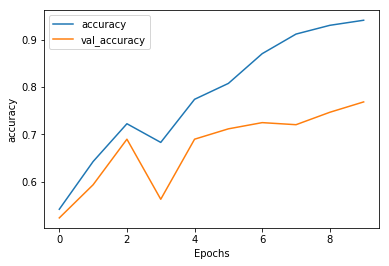

In [14]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()

plot_graphs(history_rnn, 'accuracy')

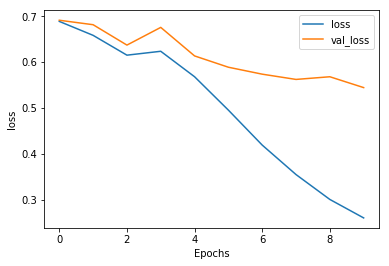

In [15]:
plot_graphs(history_rnn, 'loss')

In [16]:
results = rnn_model.evaluate(x_test, y_test)
print(results)

31/31 [==============================] - 0s 13ms/step - loss: 0.5673 - accuracy: 0.7421
[0.5673444867134094, 0.7420998811721802]
